# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

In [2]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
from IPython.display import display, Markdown

In [3]:
torch.manual_seed(0)

In [4]:
#@title Running experiments functions

def train(epochs, model, loss_fc, optimizer, train_dataloader,pretrained=False):
    model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10)
    list_loss = []
    list_accuracy = []
    for epoch in range(epochs):
        if epochs-epoch==10 and pretrained:
          for param in pretrained_model.layer4.parameters():
            param.requires_grad = True
        losses = []
        accuracy = []
        for batch_idx, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fc(outputs, targets)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            _, predicted = outputs.max(axis=1)
            accuracy.append(predicted.eq(targets).float().mean().item())

        scheduler.step()
        loss = np.array(losses).mean()
        accuracy = np.array(accuracy).mean()
        print("Epoch {:05d} | Loss: {:.4f}, Accuracy = {:.2f}%".format(epoch + 1, loss, accuracy*100))
        list_loss.append(loss)
        list_accuracy.append(accuracy)

    return accuracy, list_loss, list_accuracy

def test(model, loss_fc, test_dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    accuracy = []
    losses = []

    with torch.no_grad():
        progress_bar = tqdm(enumerate(test_dataloader), desc="Testing", total=len(test_dataloader))
        for batch_idx, (inputs, targets) in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fc(outputs, targets)

            losses.append(loss.item())
            _, predicted = outputs.max(axis=1)
            accuracy.append(predicted.eq(targets).float().mean().item())

    loss = np.array(losses).mean()
    accuracy = np.array(accuracy).mean()
    progress_bar.set_postfix({'loss': f'{loss:.3f}', 'accuracy': f'{accuracy*100:.2f}%'})
    
    return accuracy

def run_experiment( model, max_epochs, loss_fc, optimizer, train_dataloader, test_dataloader,pretrained=False):

    train_acc, list_loss, list_accuracy = train(max_epochs, model, loss_fc, optimizer, train_dataloader,pretrained)
    test_acc = test(model, loss_fc, test_dataloader)
    
    return train_acc, test_acc, list_loss, list_accuracy

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [5]:
batch_size = 16
subset_size = 100
max_epochs_1 = 30
lr=0.001
loss_fc = nn.CrossEntropyLoss()

In [6]:
#@title Download datas

transform_simple = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_simple)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_simple)

# Subset
sub_trainset = Subset(trainset, np.arange(subset_size))

# DataLoader
train_dataloader = DataLoader(sub_trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $\mathcal{X}$. 

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

The evaluation of the training procedure is difficult in this context due to several factors:

* **Small labeled dataset ($N_{train}$ is small):** With a limited number of labeled data points, training a model becomes challenging because there is not enough information to learn the underlying patterns in the data. This can lead to overfitting, where the model performs well on the training set but poorly on the test set.

* **Limited computational budget:** Without powerful computational resources, like GPUs, training complex models with large datasets becomes time-consuming and computationally expensive.

* **Large unlabeled dataset:** Although there's a large amount of unlabeled data available, these data points are not directly useful for supervised learning tasks without labels. Additionally, it's not clear how well the model will generalize to the test set given the limited labeled data.

To address these challenges, you can consider the following solutions:

* **Data augmentation:** Increase the size of the training dataset by applying various data augmentation techniques, such as rotations, translations, and flips. This can help the model learn more about the underlying patterns in the data and improve generalization.

* **Transfer learning:** Use a pre-trained model on a similar task or dataset and fine-tune it with the small labeled dataset. This can save computational resources and leverage the knowledge gained from the pre-trained model.

* **Semi-supervised learning:** Make use of the large unlabeled dataset by employing semi-supervised learning techniques, such as self-training, co-training, or pseudo-labeling. These methods can leverage the unlabeled data to improve the model's performance.

* **Active learning:** Actively query the most informative instances from the unlabeled dataset and obtain their labels. This can help focus the labeling efforts on the most valuable data points and improve model performance with fewer labeled samples.

* **Ensemble methods:** Train multiple models with different architectures or parameters and combine their predictions. This can improve generalization and reduce overfitting.

* **Regularization:** Apply regularization techniques, such as L1 or L2 regularization, to prevent overfitting and improve generalization.

* **Cross-validation:** Use cross-validation techniques to better estimate the model's performance on unseen data. This can help in model selection and hyperparameter tuning.

By applying these strategies, you can mitigate the difficulties associated with the evaluation of the training procedure given the limited labeled data and computational budget.

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [7]:
#@title ResNet architectures

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def net():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [8]:
batch_size = 16
subset_size = 100
max_epochs_1 = 30
lr=0.001
loss_fc = nn.CrossEntropyLoss()

In [9]:
transform_simple = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_simple)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_simple)

# Subset
sub_trainset = Subset(trainset, np.arange(subset_size))

# DataLoader
train_dataloader = DataLoader(sub_trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [10]:
# Define the model names
model_1 = 'ResNet18 (without pretraining)'

# Create models
model1 = net()

# Create optimizers
optimizer1 = torch.optim.Adam(model1.parameters(), lr=lr)

# Run experiments
train_acc_1, test_acc_1, list_loss_1, list_accuracy_1 = run_experiment( model1, max_epochs_1, loss_fc, optimizer1, train_dataloader, test_dataloader)

# Display table

table = f"""\
| Model | epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   {model_1} | {max_epochs_1} | {round(train_acc_1*100,2)}% | {round(test_acc_1*100,2)}% |
"""

display(Markdown(table))

Epoch 00001 | Loss: 3.4160, Accuracy = 12.50%
Epoch 00002 | Loss: 2.2651, Accuracy = 22.32%
Epoch 00003 | Loss: 1.9858, Accuracy = 29.46%
Epoch 00004 | Loss: 1.7849, Accuracy = 25.89%
Epoch 00005 | Loss: 1.4626, Accuracy = 53.57%
Epoch 00006 | Loss: 1.3442, Accuracy = 61.61%
Epoch 00007 | Loss: 1.1478, Accuracy = 64.29%
Epoch 00008 | Loss: 1.1299, Accuracy = 61.61%
Epoch 00009 | Loss: 0.9039, Accuracy = 69.64%
Epoch 00010 | Loss: 1.1326, Accuracy = 62.50%
Epoch 00011 | Loss: 0.6449, Accuracy = 80.36%
Epoch 00012 | Loss: 0.6739, Accuracy = 80.36%
Epoch 00013 | Loss: 0.5303, Accuracy = 91.07%
Epoch 00014 | Loss: 0.4707, Accuracy = 88.39%
Epoch 00015 | Loss: 0.4980, Accuracy = 91.07%
Epoch 00016 | Loss: 0.3538, Accuracy = 99.11%
Epoch 00017 | Loss: 0.3236, Accuracy = 93.75%
Epoch 00018 | Loss: 0.2294, Accuracy = 97.32%
Epoch 00019 | Loss: 0.3067, Accuracy = 93.75%
Epoch 00020 | Loss: 0.1945, Accuracy = 99.11%
Epoch 00021 | Loss: 0.3087, Accuracy = 95.54%
Epoch 00022 | Loss: 0.2534, Accura

Testing: 100%|██████████| 625/625 [00:07<00:00, 81.90it/s] 


| Model | epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 (without pretraining) | 30 | 95.54% | 24.39% |


# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [11]:
batch_size = 64
subset_size = 100
max_epochs_2 = 30
lr=0.01
loss_fc = nn.CrossEntropyLoss()

In [12]:
preprocess = ResNet18_Weights.DEFAULT.transforms()

# Sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)

# Subset
sub_trainset = Subset(trainset, np.arange(subset_size))

# DataLoader
train_dataloader = DataLoader(sub_trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# Define the model names
model_2 = 'ResNet18 (with pretraining)'

# Create models
weights = ResNet18_Weights.DEFAULT

pretrained_model = resnet18(weights = weights)

for param in pretrained_model.parameters():
    param.requires_grad = False
in_features = pretrained_model.fc.in_features

pretrained_model.fc = nn.Linear(in_features=in_features,out_features=10)

model2 = pretrained_model

# Create optimizers
optimizer = torch.optim.Adam(model2.parameters(), lr=lr)

# Run experiments
train_acc_2, test_acc_2, list_loss_2, list_accuracy_2 = run_experiment( model2, max_epochs_2, loss_fc, optimizer, train_dataloader, test_dataloader,pretrained=True)

# Display table

table = f"""\
| Model | epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   {model_1} | {max_epochs_1} | {round(train_acc_1*100,2)}% | {round(test_acc_1*100,2)}% |
|   {model_2} | {max_epochs_2} | {round(train_acc_2*100,2)}% | {round(test_acc_2*100,2)}% |
"""

display(Markdown(table))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 00001 | Loss: 3.3771, Accuracy = 14.93%
Epoch 00002 | Loss: 3.6375, Accuracy = 13.98%
Epoch 00003 | Loss: 1.9794, Accuracy = 37.41%
Epoch 00004 | Loss: 2.1019, Accuracy = 38.37%
Epoch 00005 | Loss: 1.7309, Accuracy = 47.40%
Epoch 00006 | Loss: 0.9671, Accuracy = 74.57%
Epoch 00007 | Loss: 0.7531, Accuracy = 72.05%
Epoch 00008 | Loss: 0.6716, Accuracy = 70.14%
Epoch 00009 | Loss: 0.4031, Accuracy = 90.19%
Epoch 00010 | Loss: 0.3818, Accuracy = 90.36%
Epoch 00011 | Loss: 0.3096, Accuracy = 93.49%
Epoch 00012 | Loss: 0.2961, Accuracy = 96.27%
Epoch 00013 | Loss: 0.2704, Accuracy = 95.05%
Epoch 00014 | Loss: 0.2473, Accuracy = 97.22%
Epoch 00015 | Loss: 0.2446, Accuracy = 95.83%
Epoch 00016 | Loss: 0.1932, Accuracy = 99.22%
Epoch 00017 | Loss: 0.1661, Accuracy = 100.00%
Epoch 00018 | Loss: 0.1501, Accuracy = 100.00%
Epoch 00019 | Loss: 0.1496, Accuracy = 100.00%
Epoch 00020 | Loss: 0.1458, Accuracy = 100.00%
Epoch 00021 | Loss: 0.1479, Accuracy = 100.00%
Epoch 00022 | Loss: 0.0351, A

Testing: 100%|██████████| 157/157 [00:38<00:00,  4.13it/s]


| Model | epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 (without pretraining) | 30 | 95.54% | 24.39% |
|   ResNet18 (with pretraining) | 30 | 100.0% | 53.28% |


# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that :

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

__Answer to question 5:__ When working with small-sized images, such as 32x32 images, several issues can arise when manipulating these images:

* By translating naively, some details on the border might disappear and be replaced by blank space.

* Rotations can lead to the same problems with the corner of the image.

* Scaling can also be problematic in 32x32 images, as downscaling can result in the loss of crucial details, and upsampling can make the image hard to process.

* Variations in color within images can make a big difference in how the image looks and make it harder for a computer model to recognize what’s in it.

To mitigate those issues, one can 

* Use data augmentation techniques that keep the important parts of the image while still adding some variety.

* Use interpolation techniques to preserve image quality during transformations.

* Use adaptive pooling methods to preserve important image features during downscaling, and subsampling techniques during upscaling to avoid excessive increase in image size.

* Use color normalization methods to reduce the impact of color variations in images. For example, converting the image to grayscale can help reduce the impact of color variations, or normalize the image's color channels to balance the contributions of each channel.

## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

__Answer to question 6:__ One can propose the following set of geometric transformations:

* **Rotation:** Rotate the images by a random angle within a specified range.

* **Flipping:** Flip the images horizontally or vertically with a certain probability.

* **Color Jit** Change randomly the colors of the pixels with a certain probability.

In [14]:
batch_size = 64
subset_size = 100
max_epochs_3 = 30
lr=0.001
loss_fc = nn.CrossEntropyLoss()

In [15]:
#@title Augmented data

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(hue=.02, saturation=.02),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])





trainset_augmented = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', download=True,train=False,transform=transform_test)

sub_trainset_augmented = Subset(trainset_augmented, np.arange(subset_size))
train_dataloader_augmented = DataLoader(sub_trainset_augmented, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
# Define the model names
model_3 = 'ResNet18 (with data augmentation)'

# Create models

model = net()

model3 = model

# Create optimizers
optimizer = torch.optim.Adam(model3.parameters(), lr=lr)

# Run experiments
train_acc_3, test_acc_3, list_loss_3, list_accuracy_3 = run_experiment( model3, max_epochs_3, loss_fc, optimizer,  train_dataloader_augmented, test_dataloader)

# Display table

table = f"""\
| Model | epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   {model_1} | {max_epochs_1} | {round(train_acc_1*100,2)}% | {round(test_acc_1*100,2)}% |
|   {model_2} | {max_epochs_2} | {round(train_acc_2*100,2)}% | {round(test_acc_2*100,2)}% |
|   {model_3} | {max_epochs_3} | {round(train_acc_3*100,2)}% | {round(test_acc_3*100,2)}% |
"""

display(Markdown(table))

Epoch 00001 | Loss: 2.8218, Accuracy = 14.76%
Epoch 00002 | Loss: 2.4306, Accuracy = 23.00%
Epoch 00003 | Loss: 1.9171, Accuracy = 33.07%
Epoch 00004 | Loss: 1.7087, Accuracy = 38.54%
Epoch 00005 | Loss: 1.5409, Accuracy = 47.66%
Epoch 00006 | Loss: 1.3401, Accuracy = 52.08%
Epoch 00007 | Loss: 1.0412, Accuracy = 63.02%
Epoch 00008 | Loss: 0.9322, Accuracy = 72.92%
Epoch 00009 | Loss: 0.6910, Accuracy = 77.60%
Epoch 00010 | Loss: 0.6488, Accuracy = 72.40%
Epoch 00011 | Loss: 0.5943, Accuracy = 81.51%
Epoch 00012 | Loss: 0.5091, Accuracy = 83.07%
Epoch 00013 | Loss: 0.4587, Accuracy = 85.42%
Epoch 00014 | Loss: 0.3940, Accuracy = 91.75%
Epoch 00015 | Loss: 0.3941, Accuracy = 89.32%
Epoch 00016 | Loss: 0.3002, Accuracy = 96.44%
Epoch 00017 | Loss: 0.2717, Accuracy = 96.88%
Epoch 00018 | Loss: 0.3154, Accuracy = 94.27%
Epoch 00019 | Loss: 0.2390, Accuracy = 96.88%
Epoch 00020 | Loss: 0.2092, Accuracy = 97.05%
Epoch 00021 | Loss: 0.2217, Accuracy = 99.22%
Epoch 00022 | Loss: 0.1907, Accura

Testing: 100%|██████████| 157/157 [00:05<00:00, 28.61it/s]


| Model | epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 (without pretraining) | 30 | 95.54% | 24.39% |
|   ResNet18 (with pretraining) | 30 | 100.0% | 53.28% |
|   ResNet18 (with data augmentation) | 30 | 98.61% | 23.53% |


# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

[]

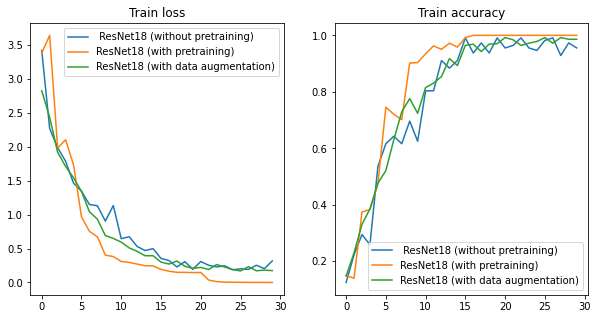

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(list_loss_1, label= " ResNet18 (without pretraining)")
plt.plot(list_loss_2, label = "ResNet18 (with pretraining)")
plt.plot(list_loss_3, label = "ResNet18 (with data augmentation)")
plt.title("Train loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(list_accuracy_1, label= " ResNet18 (without pretraining)")
plt.plot(list_accuracy_2, label = "ResNet18 (with pretraining)")
plt.plot(list_accuracy_3, label = "ResNet18 (with data augmentation)")
plt.title("Train accuracy")
plt.legend()
plt.plot()

Thoses plots show two things:

1. Although the algorithms performs well at start, they all reach a certain level of performance they cannot outpass after around 20 epochs.

2. In this case, data augmentation does not improve significantely the performances of the training.

We are going to try to explain de differencies between the simple ResNet18 and both the pretrained one and the other with data augmentation:

1. Using a pre-trained model like ResNet18 for transfer learning can save time and computational resources. Since the model has already been trained on a large dataset, it has learned to recognize many features and patterns that can be useful for image classification tasks. By fine-tuning the pre-trained model on a new dataset, one can leverage this prior knowledge to achieve better performance with less training data and in less time compared to training a model from scratch. In this example, the problem was that the training dataset was too small. By using a pre-trained model with high performances and applying it to the 100 images CIFAR10 dataset, one can obtain huge improvements within less time. One limitation of transfer learning might be that there not always exist a pre-trained model that suits our datas.

2. Data augmentation can help improve the performance of a model by increasing the number of samples inthe dataset existing using data. However, if the dataset is too small, it may not help much because the augmented data may not be diverse enough to improve the model’s performance. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes. By taking 100 images, the perfect scenario would be 10 images of each. But there are 6,000 images in each class. Thus, even with maximum diversity on the sample, 10 images multiplied by simple data augmentation cannot lead to a significant improvement.

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.